> # Assignment 4: Deep Learning

> # Packages

Download the dataset MM-IMDB from http://lisi1.unal.edu.co/mmimdb/. The dataset includes poster images from movies of different genres as well as the text of the corresponding synopses.

In [ ]:
import tensorflow as tf
import shutil
import json 
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.image as mpimg

In [ ]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

## Dataset


We download the database and unzip the file.


In [ ]:
!wget http://lisi1.unal.edu.co/mmimdb/mmimdb.tar.gz

--2020-06-16 18:56:30--  http://lisi1.unal.edu.co/mmimdb/mmimdb.tar.gz
Resolving lisi1.unal.edu.co (lisi1.unal.edu.co)... 168.176.36.11
Connecting to lisi1.unal.edu.co (lisi1.unal.edu.co)|168.176.36.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8693248518 (8.1G) [application/octet-stream]
Saving to: ‘mmimdb.tar.gz’

mmimdb.tar.gz       100%[===================>]   8.10G  8.12MB/s    in 18m 9s  

2020-06-16 19:14:39 (7.62 MB/s) - ‘mmimdb.tar.gz’ saved [8693248518/8693248518]



In [ ]:
shutil.unpack_archive("mmimdb.tar.gz")

> ## Exercise 1

Movie poster classification

We create three dataframes, one for testing, one for training and one for validation. Each dataframe with the names of the files, the reviews and the corresponding labels. We reduce the 27 genres to 23, as in the paper.

In [ ]:


# Opening JSON file 
f = open('/content/mmimdb/split.json') 
data = json.load(f) 
f.close() 
devel=np.array(data['dev'])
test=np.array(data['test']) 
train=np.array(data['train'])



In [ ]:
#[ 'News','Reality-TV', 'Talk-Show']
#[0102095] Duda



In [ ]:

df_train=pd.DataFrame(columns=['label','File_name','Plot','label_encode'],index=train)
for i in train:
  f = open('/content/mmimdb/dataset/'+i+'.json') 
  df_train.File_name[i]=i+'.jpeg'
  data2 = json.load(f)
  f.close()  
  for u in [ 'News','Reality-TV', 'Talk-Show','Adult']:
    if u in data2['genres']:
      data2['genres'].remove(u)
  df_train.label[i]=data2['genres']
  df_train.Plot[i]=data2['plot']

df_val=pd.DataFrame(columns=['label','File_name','Plot','label_encode'],index=devel)
for i in devel:
  f = open('/content/mmimdb/dataset/'+i+'.json') 
  df_val.File_name[i]=i+'.jpeg'
  data2 = json.load(f)
  f.close()
  for u in [ 'News','Reality-TV', 'Talk-Show','Adult']:
    if u in data2['genres']:
      data2['genres'].remove(u)
  df_val.label[i]=data2['genres']
  df_val.Plot[i]=data2['plot']



df_test=pd.DataFrame(columns=['label','File_name','Plot','label_encode'],index=test)
for i in test:
  f = open('/content/mmimdb/dataset/'+i+'.json') 
  df_test.File_name[i]=i+'.jpeg'
  data2 = json.load(f)
  f.close()
  for u in [ 'News','Reality-TV', 'Talk-Show','Adult']:
    if u in data2['genres']:
      data2['genres'].remove(u)
  df_test.label[i]=data2['genres']
  df_test.Plot[i]=data2['plot']




Next we encode the labels to vectors for each group (Train, Test and Validation)

In [ ]:

mlb = MultiLabelBinarizer()
mlb.fit(df_train.label)
y_train_bin = mlb.transform(df_train.label)
y_train_bin
mlb.classes_
np.shape(y_train_bin)
y_train_bin[0,:]
for u in range(len(df_train)):
  df_train['label_encode'][train[u]]=y_train_bin[u,:]


In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit(df_train.label)
y_test_bin = mlb.transform(df_test.label)
for u in range(len(df_test)):
  df_test['label_encode'][test[u]]=list(y_test_bin[u,:])


In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit(df_train.label)
y_val_bin = mlb.transform(df_val.label)
for u in range(len(df_val)):
  df_val['label_encode'][devel[u]]=y_val_bin[u,:]
# for v in range(23):
#   df_val[mlb.classes_[v]]=y_val_bin[:,v]
# df_val

> ### **(a)**
Train a deep learning model to predict the genre. Use transfer learning with and without fine tuning


---

We establish some variables.


In [ ]:

img_width, img_height = 224, 224
data_dir = '/content/mmimdb/dataset/'
nb_train_samples = len(train)#15552
nb_validation_samples = len(devel)#2608
epochs = 15
batch_size = 12
class_weight=1-(y_train_bin.sum(axis=0)/y_train_bin.sum()) #to deal with the unbalance dataset

Load the data sets from the data frames

In [ ]:

image_data_generator = ImageDataGenerator(
    validation_split=0,
    rescale=1. / 255)
train_generator = image_data_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=data_dir,
    x_col='File_name',
    y_col='label' ,
    class_mode='categorical',
    target_size=(img_width, img_height ),
    batch_size=batch_size,shuffle=False 
)
validation_generator = image_data_generator.flow_from_dataframe(
    dataframe=df_val,
    directory=data_dir,
    x_col='File_name',
    y_col='label',
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size,shuffle=False  
)

test_generator = image_data_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=data_dir,
    x_col='File_name',
    y_col='label',
    class_mode='categorical',#multi_output
    target_size=(img_width, img_height),
    batch_size=batch_size,shuffle=False  
)

Found 15552 validated image filenames belonging to 23 classes.
Found 2608 validated image filenames belonging to 23 classes.
Found 7799 validated image filenames belonging to 23 classes.


## Without fine tuning

Transfer learning, mobilenet

In [ ]:

extractor = keras.applications.MobileNet(weights='imagenet', include_top=False,
                                            input_shape=(img_width, img_height, 3))

for layer in extractor.layers:
    layer.trainable=False
pool = keras.layers.GlobalAveragePooling2D()(extractor.output)
dense1 = keras.layers.Dense(32, activation="relu")(pool)
drop1 = keras.layers.Dropout(0.2)(dense1)
dense2 = keras.layers.Dense(23, activation="sigmoid")(drop1)
tl_model = keras.models.Model(inputs=[extractor.input], outputs=[dense2])

#tl_model.summary()


Compile and fit the model

In [ ]:

tl_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-5),
                 metrics=[tf.keras.metrics.CategoricalAccuracy()])
tl_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,class_weight=class_weight)

Epoch 1/15
1296/1296 [==============================] - 441s 340ms/step - loss: 0.4636 - categorical_accuracy: 0.0701 - val_loss: 0.3470 - val_categorical_accuracy: 0.1258
Epoch 2/15
1296/1296 [==============================] - 431s 333ms/step - loss: 0.3808 - categorical_accuracy: 0.1498 - val_loss: 0.3408 - val_categorical_accuracy: 0.1639
Epoch 3/15
1296/1296 [==============================] - 431s 332ms/step - loss: 0.3613 - categorical_accuracy: 0.1741 - val_loss: 0.2989 - val_categorical_accuracy: 0.1824
Epoch 4/15
1296/1296 [==============================] - 429s 331ms/step - loss: 0.3480 - categorical_accuracy: 0.1884 - val_loss: 0.3101 - val_categorical_accuracy: 0.1935
Epoch 5/15
1296/1296 [==============================] - 435s 336ms/step - loss: 0.3373 - categorical_accuracy: 0.1977 - val_loss: 0.3696 - val_categorical_accuracy: 0.2014
Epoch 6/15
1296/1296 [==============================] - 431s 332ms/step - loss: 0.3299 - categorical_accuracy: 0.2049 - val_loss: 0.3078 - v

In [ ]:
tl_model.save('1_SFT.h5')

Implemet the model in some of the test images.

In [ ]:
#Preprocessing
ims = [keras.preprocessing.image.load_img(i, target_size=(224, 224, 3))\
       for i in ['/content/mmimdb/dataset/'+test[10]+'.jpeg','/content/mmimdb/dataset/'+test[20]+'.jpeg','/content/mmimdb/dataset/'+test[30]+'.jpeg','/content/mmimdb/dataset/'+test[40]+'.jpeg']]
ims = np.array(list(map(np.array, ims)))
ims_prep = keras.applications.mobilenet.preprocess_input(ims.copy())


True labels

In [ ]:

df_test.label[[test[10],test[20],test[30],test[40]]]

0023369                                [Drama]
1722450               [Comedy, Drama, Romance]
0386117    [Adventure, Drama, Family, Fantasy]
0071877                [Crime, Drama, Mystery]
Name: label, dtype: object

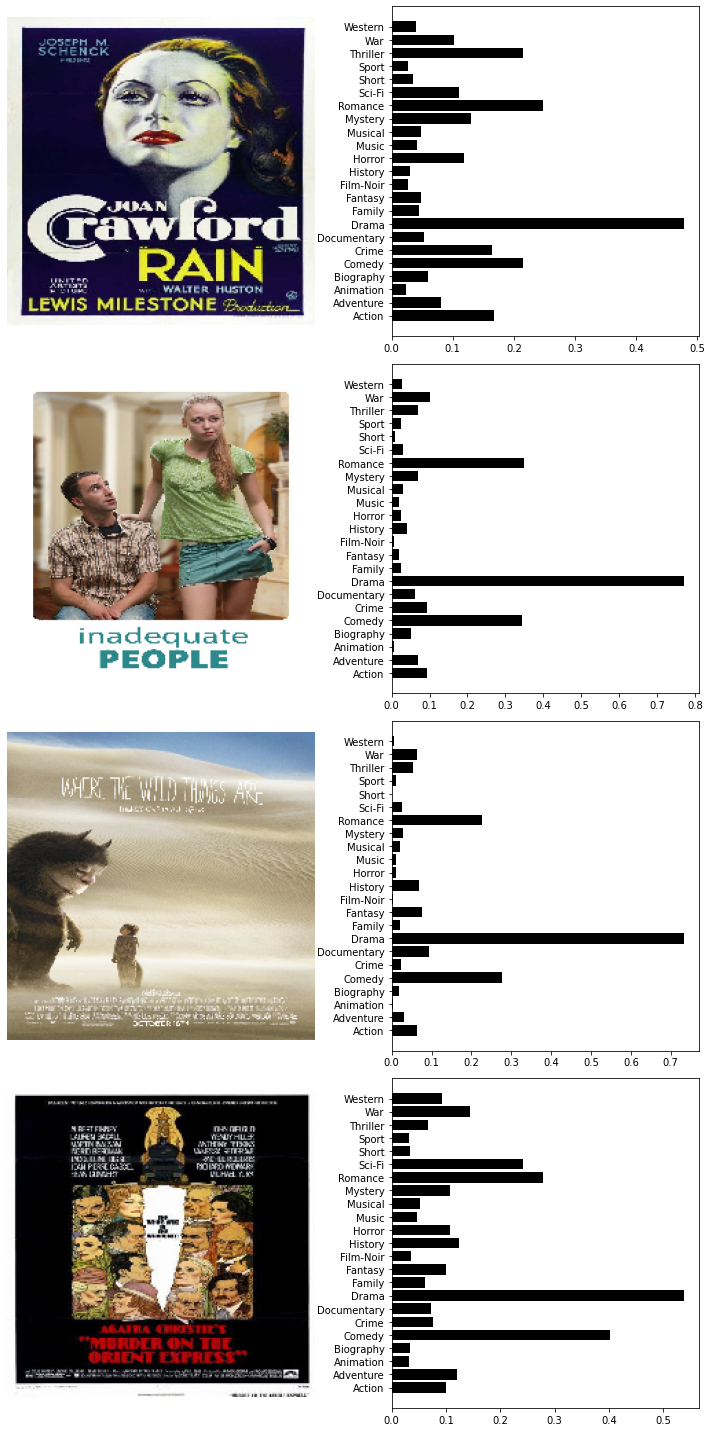

In [ ]:
# get the predictions
preds = tl_model.predict(ims_prep)
#labels
labs = mlb.classes_
#Show the posters and the probabilities for each label
fig, ax = plt.subplots(4, 2, figsize=(10,20))
for i in range(4):
    ax[i, 0].imshow(ims[i]); ax[i, 0].axis("off")
    ax[i, 1].barh(labs,preds[i], color="k")
fig.tight_layout()


### Classifier performance

In [ ]:
#prediction of test set
predic = tl_model.predict(test_generator)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


The model gave us a vector with the probabilities of having each of the 23 labels. We decided to leave the threshold at 0.5 to assign the labels.

In [ ]:
def bina(mt,tr):
  m,n=mt.shape
  re=np.zeros([m,n])
  for u in range(m):
    for v in range(n):
      if mt[u][v]>tr:
        re[u][v]=1
  return re


In [ ]:
y_pred=bina(predic,0.5)

score=f1_score(y_test_bin,y_pred,average='micro')
scoreb=f1_score(y_test_bin,y_pred,average='macro')


In [ ]:
print(classification_report(y_test_bin, y_pred, target_names=mlb.classes_))

              precision    recall  f1-score   support

      Action       0.50      0.00      0.00      1044
   Adventure       0.00      0.00      0.00       821
   Animation       1.00      0.00      0.01       306
   Biography       0.00      0.00      0.00       411
      Comedy       0.59      0.27      0.37      2611
       Crime       0.00      0.00      0.00      1163
 Documentary       0.00      0.00      0.00       629
       Drama       0.57      0.81      0.67      4142
      Family       0.00      0.00      0.00       518
     Fantasy       0.00      0.00      0.00       585
   Film-Noir       0.00      0.00      0.00       102
     History       0.00      0.00      0.00       345
      Horror       0.00      0.00      0.00       825
       Music       0.00      0.00      0.00       311
     Musical       0.00      0.00      0.00       253
     Mystery       0.00      0.00      0.00       617
     Romance       0.37      0.02      0.03      1590
      Sci-Fi       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# ims = [keras.preprocessing.image.load_img('/content/mmimdb/dataset/'+i+'.jpeg', target_size=(224, 224, 3))\
#        for i in test]

In [ ]:
# for u in test:
#   print(u)
#   keras.preprocessing.image.load_img('/content/mmimdb/dataset/'+u+'.jpeg', target_size=(224, 224, 3))

# keras.preprocessing.image.load_img('/content/mmimdb/dataset/'+test[3000]+'.jpeg', target_size=(224, 224, 3))

## Fine tuning

In [ ]:
extractor = keras.applications.MobileNet(weights='imagenet', include_top=False,
                                            input_shape=(img_width, img_height, 3))
pool = keras.layers.GlobalAveragePooling2D()(extractor.output)
dense1 = keras.layers.Dense(32, activation="relu")(pool)
drop1 = keras.layers.Dropout(0.2)(dense1)
dense2 = keras.layers.Dense(23, activation="sigmoid")(drop1)
t2_model = keras.models.Model(inputs=[extractor.input], outputs=[dense2])


In [ ]:
# Unfreeze the extractor layers
for layer in t2_model.layers[-23:]:
    layer.trainable = True

# Learning rate
t2_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-5),
                 metrics=[tf.keras.metrics.CategoricalAccuracy() ])#'acuracy' macro_f1

# train

t2_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,#
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,class_weight=class_weight)



Epoch 1/15
1296/1296 [==============================] - 674s 520ms/step - loss: 0.5442 - categorical_accuracy: 0.0627 - val_loss: 0.4103 - val_categorical_accuracy: 0.0492
Epoch 2/15
1296/1296 [==============================] - 655s 505ms/step - loss: 0.4073 - categorical_accuracy: 0.0662 - val_loss: 0.3170 - val_categorical_accuracy: 0.0948
Epoch 3/15
1296/1296 [==============================] - 692s 534ms/step - loss: 0.3520 - categorical_accuracy: 0.1186 - val_loss: 0.2556 - val_categorical_accuracy: 0.1380
Epoch 4/15
1296/1296 [==============================] - 689s 532ms/step - loss: 0.3217 - categorical_accuracy: 0.1556 - val_loss: 0.2795 - val_categorical_accuracy: 0.1702
Epoch 5/15
1296/1296 [==============================] - 660s 510ms/step - loss: 0.3003 - categorical_accuracy: 0.1828 - val_loss: 0.3699 - val_categorical_accuracy: 0.1944
Epoch 6/15
1296/1296 [==============================] - 645s 498ms/step - loss: 0.2864 - categorical_accuracy: 0.2042 - val_loss: 0.2771 - v

In [ ]:
t2_model.save('1_FT.h5')

In [ ]:
#prediction of test set
predic2 = t2_model.predict(test_generator)
y_pred2=bina(predic2,0.5)
score2=f1_score(y_test_bin,y_pred2,average='micro')
score2b=f1_score(y_test_bin,y_pred2,average='macro')


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
print(classification_report(y_test_bin, y_pred2, target_names=mlb.classes_))

              precision    recall  f1-score   support

      Action       0.59      0.09      0.15      1044
   Adventure       0.52      0.06      0.11       821
   Animation       0.85      0.31      0.45       306
   Biography       0.00      0.00      0.00       411
      Comedy       0.60      0.56      0.58      2611
       Crime       0.49      0.02      0.04      1163
 Documentary       0.17      0.00      0.00       629
       Drama       0.65      0.70      0.67      4142
      Family       0.85      0.21      0.34       518
     Fantasy       0.42      0.09      0.14       585
   Film-Noir       0.00      0.00      0.00       102
     History       0.00      0.00      0.00       345
      Horror       0.63      0.07      0.12       825
       Music       0.00      0.00      0.00       311
     Musical       0.67      0.01      0.02       253
     Mystery       0.00      0.00      0.00       617
     Romance       0.44      0.25      0.32      1590
      Sci-Fi       0.80    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


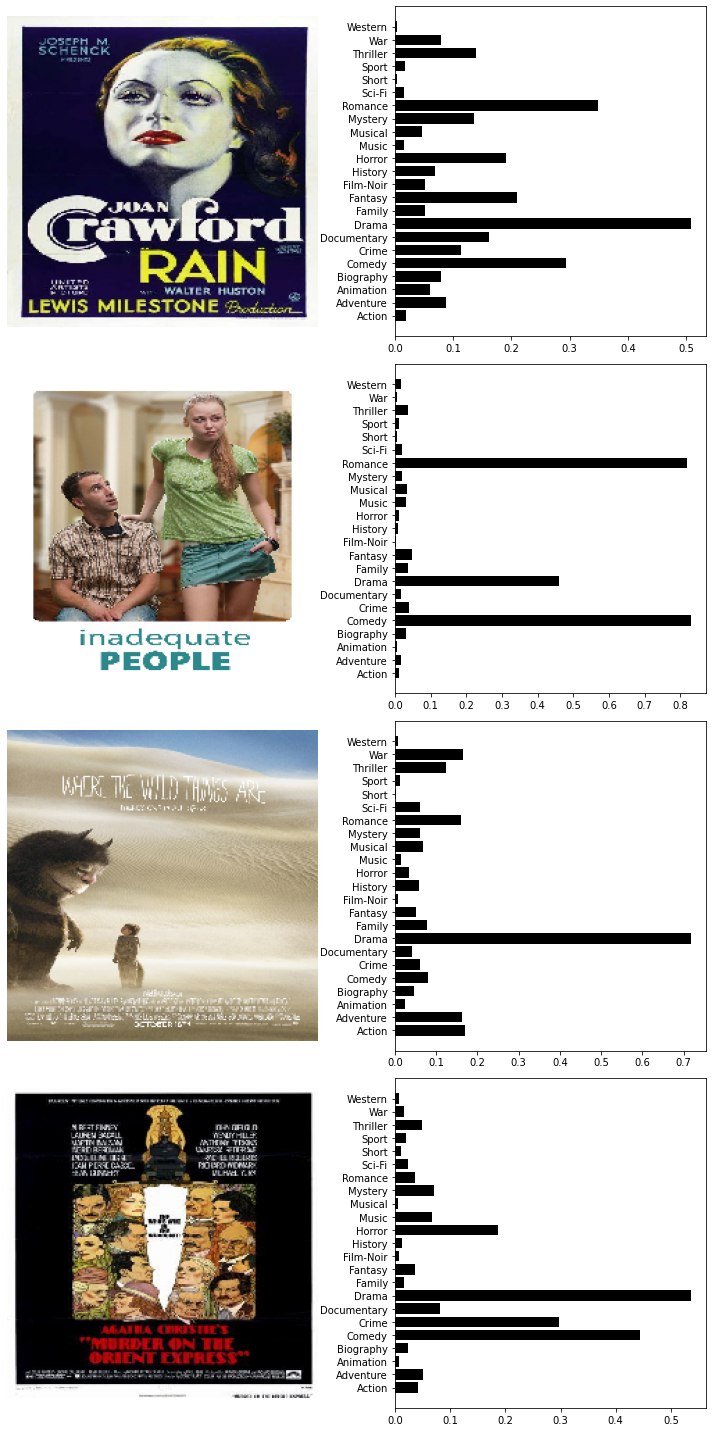

In [ ]:
# obtenemos las predicciones
preds = t2_model.predict(ims_prep)
labs = mlb.classes_
fig, ax = plt.subplots(4, 2, figsize=(10,20))
for i in range(4):
    ax[i, 0].imshow(ims[i]); ax[i, 0].axis("off")
    ax[i, 1].barh(labs,preds[i], color="k")
fig.tight_layout()


> ### **(b)** 
Evaluate and analyze the results. Use the same evaluation metrics reported in the original paper. Compare your results with the ones reported in the paper. Discuss the results.


---



##Scores

In [ ]:
dt=pd.DataFrame([[score,scoreb],[score2,score2b]],columns=['F1_score (micro)','F1_score (macro)'],index=['no fine_tunning','fine_tunning'])
dt

F1_score (micro)  F1_score (macro)
no fine_tunning          0.308580          0.046973
fine_tunning             0.385856          0.140028

As in the last table is shown the model with the best perfomance (highest f1-score macro/micro) is the one that use tunning, but the difference is't to much. In general the model is not very good because, altoght we take into count weights for the classes to face the fact that the data is not balance. The model tends to have a lot of false negative for the not well representen labels like Film-Noir. With respect to the f1-score macro/micro our model don't reach a better performance the the ones on the paper, meaby because of the choosen variables.  For the tunning model is importan to notice that it's capable of classify correctly poster the other model can't (it has more true positives of labels as adventure). 

> ## Exercise 2
Movie synopsis classification

> ### **(a)**
Train a recurrent neural network over the movie synopsis texts to predict the movie genre.


---



we show our dataset below 

In [ ]:
df_train.head(5)

label  ...                                       label_encode
0106714          [Crime, Drama, Thriller]  ...  [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
0204504  [Action, Crime, Drama, Thriller]  ...  [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
1865357                           [Drama]  ...  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
0033804                 [Comedy, Romance]  ...  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
0066423                          [Comedy]  ...  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

[5 rows x 4 columns]

DWe decided to pre-process the data before starting, here we leave the dataset entries as a character string instead of arrays.

In [ ]:
n_rows, n_cols = df_train.shape

for i in range(n_rows):
  phrase = str(df_train['label'][i][:])
  phrase = re.sub("[[']", "", phrase)
  phrase = re.sub("[]]", "", phrase)
  df_train['label'][i] = phrase 

for i in range(n_rows):
  df_train['Plot'][i] = df_train['Plot'][i][0]


n_rows, n_cols = df_test.shape

for i in range(n_rows):
  phrase = str(df_test['label'][i][:])
  phrase = re.sub("[[']", "", phrase)
  phrase = re.sub("[]]", "", phrase)
  df_test['label'][i] = phrase 

for i in range(n_rows):
  df_test['Plot'][i] = df_test['Plot'][i][0]


n_rows, n_cols = df_val.shape

for i in range(n_rows):
  phrase = str(df_val['label'][i][:])
  phrase = re.sub("[[']", "", phrase)
  phrase = re.sub("[]]", "", phrase)
  df_val['label'][i] = phrase 

for i in range(n_rows):
  df_val['Plot'][i] = df_val['Plot'][i][0]


Here we remove some stopwords and special characters from our dataset

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

we apply data cleaning to all three subsets: train, test and validation

In [ ]:
preprocessed_synopsis = []
# tqdm is for printing the status bar
for sentence in df_train['Plot'].values:
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_synopsis.append(sentence.strip())
df_train['preprocessed_plots']=preprocessed_synopsis

In [ ]:
preprocessed_synopsis = []
# tqdm is for printing the status bar
for sentence in df_test['Plot'].values:
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_synopsis.append(sentence.strip())
df_test['preprocessed_plots']=preprocessed_synopsis

In [ ]:
preprocessed_synopsis = []
# tqdm is for printing the status bar
for sentence in df_val['Plot'].values:
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_synopsis.append(sentence.strip())
df_val['preprocessed_plots']=preprocessed_synopsis

In [ ]:
def remove_spaces(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.lstrip()
        nospace.append(item)
    return (",").join(nospace)

df_train['label']=df_train['label'].apply(remove_spaces)
df_test['label']=df_test['label'].apply(remove_spaces)
df_val['label']=df_val['label'].apply(remove_spaces)
train = df_train
train = train.reset_index()
cv = df_val
cv = cv.reset_index()
test = df_test
test = test.reset_index()

We prepare the labels for training and testing. Because this is a multi-label classification, the output labels need to be one-hot-coded. We have used Bag of words technique using the sci-kit learn method for this.

In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
y_train = vectorizer.fit_transform(train['label']).toarray()
y_test = vectorizer.transform(test['label']).toarray()

In [ ]:
def max_len(x):
    a=x.split()
    return len(a)
    
#max(df_train['Plot'].apply(max_len))
#max(df_test['Plot'].apply(max_len))
max(df_val['Plot'].apply(max_len))

1649

In [ ]:
vect = Tokenizer()
vect.fit_on_texts(train['Plot'])
vocab_size = len(vect.word_index) + 1
print(vocab_size)

55639


In [ ]:
encoded_docs_train = vect.texts_to_sequences(train['preprocessed_plots'])
#max_length = vocab_size
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=1649, padding='post')
print(padded_docs_train)

[[ 3751  4472   991 ...     0     0     0]
 [  838   104  5762 ...     0     0     0]
 [18980   250   918 ...     0     0     0]
 ...
 [ 5292   915  2551 ...     0     0     0]
 [ 5292  2372  5292 ...     0     0     0]
 [   64  1626   168 ...     0     0     0]]


In [ ]:
padded_docs_train.shape

(15552, 1649)

Padding and making all input sequences of the same length and preparing input sequences

In [ ]:
encoded_docs_test =  vect.texts_to_sequences(test['preprocessed_plots'])
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=1649, padding='post')
encoded_docs_cv = vect.texts_to_sequences(cv['preprocessed_plots'])
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=1649, padding='post')

In [ ]:
padded_docs_cv

array([[   47,   211,   182, ...,     0,     0,     0],
       [  904,  1098, 11517, ...,     0,     0,     0],
       [  729,   186,   187, ...,     0,     0,     0],
       ...,
       [   45,  1023,  1186, ...,     0,     0,     0],
       [ 4638,   350,  5127, ...,     0,     0,     0],
       [ 1036,  1745,    39, ...,     0,     0,     0]], dtype=int32)

We use the embedding layer as the first layer for this problem and a 23 dimension dense layer as the output layer which correspond to the total number of unique tags

In [ ]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=50, input_length=1649))
model.add(LSTM(128, return_sequences=True))  
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
n_classes = 23
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1649, 50)          2781950   
_________________________________________________________________
lstm (LSTM)                  (None, 1649, 128)         91648     
_________________________________________________________________
dropout (Dropout)            (None, 1649, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 23)                1495      
Total params: 2,924,501
Trainable params: 2,924,501
Non-trainable params: 0
______________________________________________

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
padded_docs_train.shape

(15552, 1649)

we use the following weights to fit the model

In [ ]:
class_weight = {0: 0.94421723,
                1: 0.95829882,
                2: 0.98483123,
                3: 0.9796024,
                4: 0.86777801,
                5: 0.94064506,
                6: 0.96805757,
                7: 0.78194243,
                8: 0.9746842,
                9: 0.96992131,
                10: 0.99477117,
                11: 0.98239801,
                12: 0.9585059,
                13: 0.98358873,
                14: 0.98697971,
                15: 0.96813522,
                16: 0.9164941,
                17: 0.96862704,
                18: 0.99272624,
                19: 0.99018948,
                20: 0.91941913,
                21: 0.97913647,
                22: 0.98905053}

In [ ]:
history = model.fit(padded_docs_train, 
                    y_train,
                    class_weight = class_weight, 
                    epochs=15, 
                    batch_size=16, 
                    validation_split = 0.1,
                    #validation_data = padded_docs_cv,
                    callbacks = None)

Epoch 1/5
438/438 [==============================] - 1658s 4s/step - loss: 0.2870 - val_loss: 0.2843
Epoch 2/5
438/438 [==============================] - 1664s 4s/step - loss: 0.2681 - val_loss: 0.2843
Epoch 3/5
438/438 [==============================] - 1679s 4s/step - loss: 0.2661 - val_loss: 0.2841
Epoch 4/5
438/438 [==============================] - 1671s 4s/step - loss: 0.2644 - val_loss: 0.2840
Epoch 5/5
438/438 [==============================] - 1674s 4s/step - loss: 0.2641 - val_loss: 0.2844


We can see in the following image the LSTM model being adjusted with different parameters, however the results obtained for that configuration were not the best. We left evidence of the tests we did even though this was time consuming.

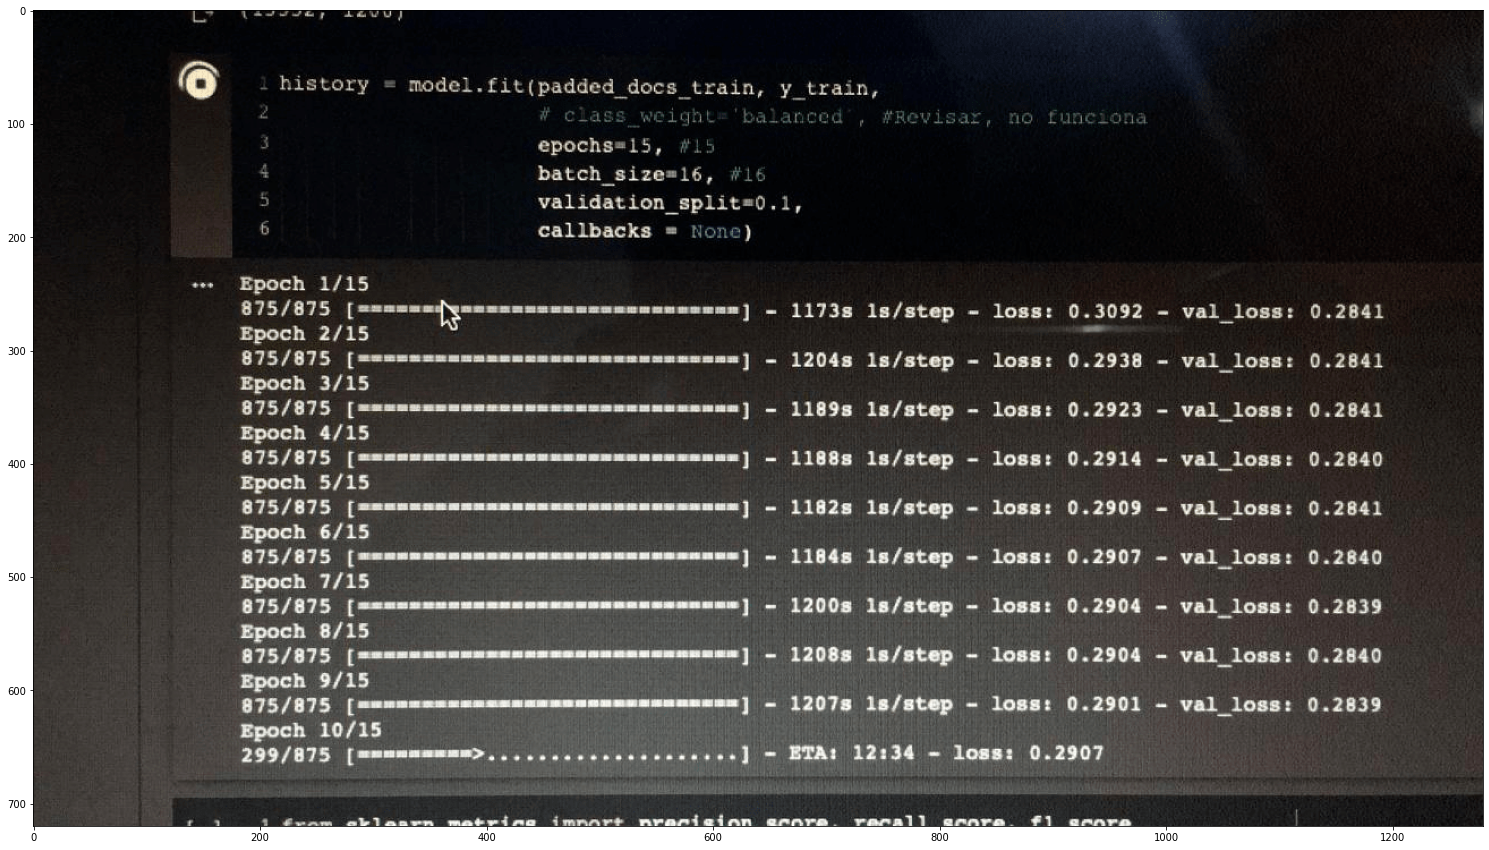

<Figure size 20736x20736 with 0 Axes>

In [ ]:
img=mpimg.imread('model_2.png')
imgplot = plt.imshow(img)
plt.figure(figsize=(288,288))
plt.rcParams["figure.figsize"] = [30,15]

In [ ]:
# padded_docs_test
model.variables
preds=bina(predictions,0.5)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
predictions=model.predict([padded_docs_test])
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision_mi = precision_score(y_test, pred, average='micro',zero_division=0)
    recall_mi = recall_score(y_test, pred, average='micro',zero_division=0)
    f1_mi = f1_score(y_test, pred, average='micro',zero_division=0)

    precision_ma = precision_score(y_test, pred, average='macro',zero_division=0)
    recall_ma = recall_score(y_test, pred, average='macro',zero_division=0)
    f1_ma = f1_score(y_test, pred, average='macro',zero_division=0)
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_mi, recall_mi, f1_mi))

    print("Macro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_mi, recall_mi, f1_mi))

Micro-average quality numbers
Precision: 0.2206, Recall: 0.7105, F1-measure: 0.3367
Macro-average quality numbers
Precision: 0.2206, Recall: 0.7105, F1-measure: 0.3367
Micro-average quality numbers
Precision: 0.3556, Recall: 0.4295, F1-measure: 0.3891
Macro-average quality numbers
Precision: 0.3556, Recall: 0.4295, F1-measure: 0.3891
Micro-average quality numbers
Precision: 0.4329, Recall: 0.3486, F1-measure: 0.3862
Macro-average quality numbers
Precision: 0.4329, Recall: 0.3486, F1-measure: 0.3862
Micro-average quality numbers
Precision: 0.5311, Recall: 0.2138, F1-measure: 0.3049
Macro-average quality numbers
Precision: 0.5311, Recall: 0.2138, F1-measure: 0.3049
Micro-average quality numbers
Precision: 0.5311, Recall: 0.2138, F1-measure: 0.3049
Macro-average quality numbers
Precision: 0.5311, Recall: 0.2138, F1-measure: 0.3049
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
Macro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure:

we save the results obtained in the model with this function 

In [ ]:
model.save('lstm_model.h5')

In [ ]:
from keras.models import load_model

In [ ]:
preds=bina(model.predict([padded_docs_test]),0.5)

In [ ]:
print(classification_report(y_test, preds, target_names=mlb.classes_))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00      1044
   Adventure       0.00      0.00      0.00       821
   Animation       0.00      0.00      0.00       306
   Biography       0.00      0.00      0.00       411
      Comedy       0.00      0.00      0.00      2611
       Crime       0.00      0.00      0.00      1163
 Documentary       0.00      0.00      0.00       629
       Drama       0.53      1.00      0.69      4142
      Family       0.00      0.00      0.00       518
     Fantasy       0.00      0.00      0.00       585
   Film-Noir       0.00      0.00      0.00       102
     History       0.00      0.00      0.00       345
      Horror       0.00      0.00      0.00       825
       Music       0.00      0.00      0.00       311
     Musical       0.00      0.00      0.00       253
     Mystery       0.00      0.00      0.00       617
     Romance       0.00      0.00      0.00      1590
      Sci-Fi       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> ### **(b)**
Evaluate and analyze the results. Compare your results with the ones reported in the paper. Discuss the results.


---



In [ ]:
f1_mi = f1_score(y_test, preds, average='micro')
f1_ma = f1_score(y_test, preds, average='macro')
pd.DataFrame([[f1_mi,f1_ma]],columns=['F1 score (Micro)','F1 score (macro)'],index=['Plot model'])


F1 score (Micro)  F1 score (macro)
Plot model          0.304906          0.030163

Comparing our results with those obtained in the paper we can see that the metrics are lower than those obtained in the paper. We see that the value that is closest to our model is using the RNN end2end representation of the paper whose F1-micro value was 0.49 and ours 0.3. We believe that part of the difficulty in reaching higher values stems from the computational ability to test new parameter settings, such as epoch and batch size variations.

We could also observe that the best represented genre in the dataset is drama, since the metrics for this genre were the best, we believe that it is necessary to assign weights to the other genres since we are facing an unbalanced dataset.

> ## Exercise 3
Multimodal movie classification

> ### **(a)**
Create a model than combines the models from the question 1 and 2 for multimodal movie classification. Clearly explain your approach. Include a diagram of your model. Train the model.


---



In [ ]:
modelt = tf.keras.models.load_model('lstm_model.h5')
modelv = tf.keras.models.load_model('1_FT.h5')

In [ ]:
#Erase the last layer of bouth models
modelt.layers.pop()
modelv.layers.pop()

In [ ]:
#Load the outputs of bouth models for trian and test set
predicv = modelv.predict(train_generator)#poster
predict = modelt.predict([padded_docs_train])#plot
predicv_test = modelv.predict(test_generator)#poster
predict_test = modelt.predict([padded_docs_test])#plot

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
#Adding new layers

for layer in modelt.layers:
    layer.trainable=False

for layer in modelv.layers:#
    layer.trainable=False



inpt=tf.keras.Input((23))
inpv=tf.keras.Input((23))
h_t = tf.keras.layers.Dense(23, activation='tanh')(inpt)
h_v = tf.keras.layers.Dense(23, activation='tanh')(inpv)

z = tf.keras.layers.Dense(1, activation='sigmoid')(tf.keras.layers.concatenate([inpt,inpv]))
h = (z)*(h_v) + (1-(z))*(h_t)
c = tf.keras.layers.Dense(23, activation='sigmoid')(h)
modelmu = tf.keras.Model(inputs=[inpt,inpv], outputs=h)

modelmu.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

We use the two previews models to process the input data and get another representation of the data. And the we add several leyers to add the GMU proposed in the papper to combine the models. 

In [ ]:
#fit the multimodal model
modelmu.fit(x=[predict,predicv],y=y_train_bin, batch_size=15,epochs=15)

Epoch 1/15
1037/1037 [==============================] - 2s 2ms/step - loss: 0.6639 - categorical_accuracy: 0.0374
Epoch 2/15
1037/1037 [==============================] - 2s 2ms/step - loss: 0.6461 - categorical_accuracy: 0.0363
Epoch 3/15
1037/1037 [==============================] - 2s 2ms/step - loss: 0.6296 - categorical_accuracy: 0.0372
Epoch 4/15
1037/1037 [==============================] - 2s 2ms/step - loss: 0.6156 - categorical_accuracy: 0.0398
Epoch 5/15
1037/1037 [==============================] - 2s 2ms/step - loss: 0.6028 - categorical_accuracy: 0.0434
Epoch 6/15
1037/1037 [==============================] - 2s 2ms/step - loss: 0.5888 - categorical_accuracy: 0.0554
Epoch 7/15
1037/1037 [==============================] - 2s 2ms/step - loss: 0.5725 - categorical_accuracy: 0.0783
Epoch 8/15
1037/1037 [==============================] - 2s 2ms/step - loss: 0.5566 - categorical_accuracy: 0.1255
Epoch 9/15
1037/1037 [==============================] - 2s 2ms/step - loss: 0.5455 - cat

In [ ]:
img=mpimg.imread('multimodel.png')

For the multinomial model we propose the following architecture that takes the prediction obtained through images and text as input and performs a linear combination between the two to obtain the classification output

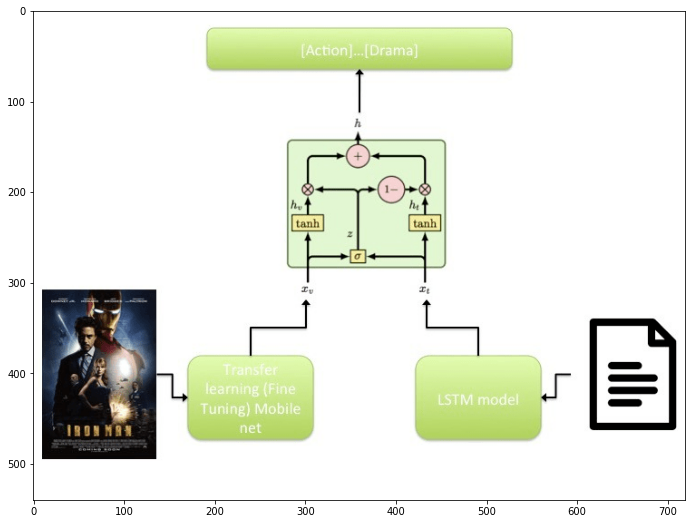

<Figure size 20736x20736 with 0 Axes>

In [ ]:
imgplot = plt.imshow(img)
plt.figure(figsize=(288,288))
plt.rcParams["figure.figsize"] = [30,15]

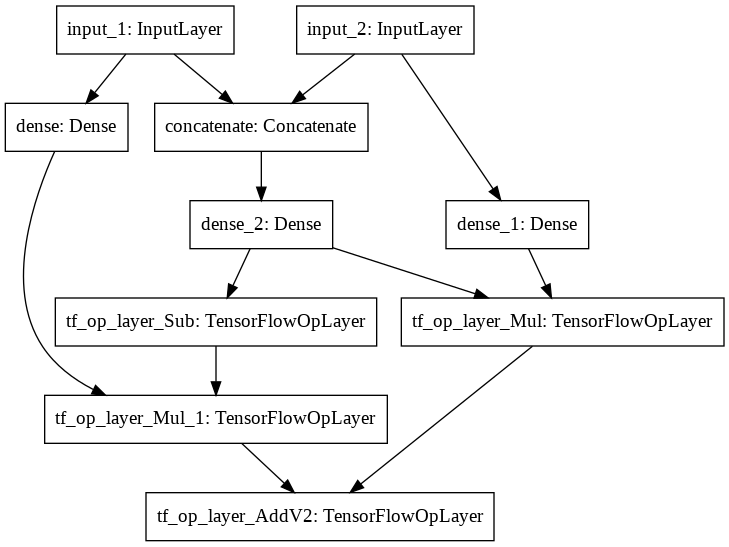

In [ ]:
tf.keras.utils.plot_model(modelmu, "Multimodel_model.png")

> ### **(b)**
Evaluate and analyze the results. Compare the results with the ones of the two previous questions. Find a recent paper (2019-2020) that uses the same dataset. Compare your results against the results reported in the original and the new paper.


---



## Scores
Model evaluation

In [ ]:
ymu=modelmu.predict([predict_test,predicv_test])
ymub=bina(ymu,0.5)

score=f1_score(y_test_bin,ymub,average='micro')
scoreb=f1_score(y_test_bin,ymub,average='macro')
print(classification_report(y_test_bin, ymub, target_names=mlb.classes_))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00      1044
   Adventure       0.00      0.00      0.00       821
   Animation       0.00      0.00      0.00       306
   Biography       0.00      0.00      0.00       411
      Comedy       0.00      0.00      0.00      2611
       Crime       0.00      0.00      0.00      1163
 Documentary       0.00      0.00      0.00       629
       Drama       0.14      0.00      0.00      4142
      Family       0.00      0.00      0.00       518
     Fantasy       0.00      0.00      0.00       585
   Film-Noir       0.00      0.00      0.00       102
     History       0.00      0.00      0.00       345
      Horror       0.00      0.00      0.00       825
       Music       0.00      0.00      0.00       311
     Musical       0.00      0.00      0.00       253
     Mystery       0.00      0.00      0.00       617
     Romance       0.00      0.00      0.00      1590
      Sci-Fi       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusions

The results between the 3 models show us that in prediction issues the GMU model with linear sum form loses predictive power in relation to the convolutional models and LSTM. Well, the multimodal model in both the micro and macro F1 scores does not have a good score. And, difference between F1 macro and  F1 micro indicate an unbalanced data in each class.

In [ ]:
scoremu=f1_score(y_test_bin,ymub,average='micro')
scorebmu=f1_score(y_test_bin,ymub,average='macro')

# =0
scoreb2=0.140028
score2=0.385856

f1_mi=0.304906
f1_ma=	0.030163
dt=pd.DataFrame([[scoremu,scorebmu],[score2,scoreb2],[f1_mi,f1_ma]],columns=['F1_score (micro)','F1_score (macro)'],index=['Multimodal','Posters, with fine tunning','Synopsis, LSTM'])#poner los scores q faltan
dt

F1_score (micro)  F1_score (macro)
Multimodal                          0.001029          0.000206
Posters, with fine tunning          0.385856          0.140028
Synopsis, LSTM                      0.304906          0.030163

With others papers, for GMU with linear sum combination:



In [ ]:
import pandas as pd
dt=pd.DataFrame([[0.617,0.520],[ 0.607,0.530],[0.001029,0.000206]],columns=['F1_score (micro)','F1_score (macro)'],index=['Arevalo & others 2019','Arevalo & others 2017','Assigment 4'])
dt

F1_score (micro)  F1_score (macro)
Arevalo & others 2019          0.617000          0.520000
Arevalo & others 2017          0.607000          0.530000
Assigment 4                    0.001029          0.000206

The two documents from Arevalo and others show that their models do not have great differences in linear combination, because their F1 scores are similar. However, they are quite high compared to the assignment, because different parameter settings like batch_size and epochs were not performed. Also, this difference with the two documents analyzed is due to that no other type of bimodal combination architectures were tested.




### References:

Arevalo, J., Solorio, T., Montes-y-Gómez, M., & Gonzalez, F. (2019). Gated multimodal networks. Neural Computing and Applications.

Arevalo, J., Solorio, T., Montes-y-Gómez, M., & González, F. A. (2017). Gated multimodal units for information fusion. In: 5th International conference on learning representations 2017 workshop


> ### The assignment must be submitted as a Jupyter notebook through the following Dropbox file request, before midnight of the deadline date. The file must be named as ml-assign4-unalusername1- unalusername2-unalusername3.ipynb, where unalusername is the user name assigned by the university (include the usernames of all the members of the group). In case you need to include supporting files in addition to the notebook, submit a zipped file containing all the files and the notebook. Make sure that the notebook renders correctly and is free of errors before submitting.